In [21]:
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
import pandas as pd

In [22]:
# mount your google drive to access the dataset file
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [23]:
# navigate through filesystem to where the file is
os.chdir('/content/drive/My Drive/')

In [24]:
class RidgeRegressionCV:
    def __init__(self, preds, responses, lambdas, nfolds = 5, alpha = 1e-4, n_iters = 1000):
        '''
        A class that implements ridge regression with cross validation to identify the optimal
        tuning parameter.

        Args:
            preds (np.ndarray): A N x M array where N is the number of samples and M is the 
                number of predictors or features.
            responses (np.ndarray): A N-dimensional vector of responses corresponding to 
                preds.
            lambdas (list): The different values of lambda to try.
            nfolds (int): The number of cross validation folds to use for each lambda given.
                Default is 5.
            alpha (float > 0): The learning rate. Default is 1e-4.
            n_iters (int > 0): The number of updates to the coefficient vector before stopping. 
        '''

        self.x, self.y = self._shuffle_data(preds, responses)
        self.lambdas = lambdas 
        self.nfolds = nfolds
        self.alpha = alpha 
        self.n_iters = n_iters
        self._initialize()


    def _initialize(self):
        '''
        This function initializes certain values needed for training and checks that certain
        arguments have appropriate values. 
        '''

        # get number of samples and number of features
        self.n_samples = self.x.shape[0]
        self.n_preds = self.x.shape[1]
    
        # matrix to store the cross validation results 
        self.cv_vals = np.zeros([self.nfolds, len(self.lambdas)])

        # determine the number of validation samples and their inds based on nfolds 
        self.n_val_samples = self.n_samples // self.nfolds 
        self.val_inds = list(range(0, self.n_samples, self.n_val_samples))

        # create a tensor to store the Betas 
        self.B_trained = np.zeros([self.nfolds, len(self.lambdas), self.n_preds])

        assert(all([lambda_val >= 0 for lambda_val in self.lambdas])), \
            'lambdas must not contain any negative values.'
        assert(self.alpha > 0), \
            'alpha must be positive.'
        assert(self.x.shape[0] == self.y.shape[0]), \
            "number of responses doesn't equal number of rows in preds."
        assert(self.n_iters > 0), \
            'n_iters should be > 0.'

    def _standardize(self, x, mean_vec, std_vec):
        '''
        Standardizes the columns of the design matrix (i.e. makes each column zero-centered 
        with a standard deviation of 1).
        
        Args:
            x (np.ndarray): The N x M design matrix with columns to be standardized.
            mean_vec (np.ndarray): The M-dimentional vector representing the means of the columns of x.
            std_vec (np.ndarray): The M-dimensional vector representing the stds of the columns of x.

        Returns:
            x_standardized (np.ndarray): The N x M design matrix, where the columns now have mean 0 and std 1.
        '''

        return (x - mean_vec) / std_vec 

    def _center_responses(self, y, mean):
        '''
        Centers a vector of responses around the mean by subtracting the given mean from every element in y. 

        Args: 
            y (np.ndarray): The N-dimensional vector of responses. 
            mean (np.ndarray): A float to subtract from the responses in y.

        Returns:
            y_centered (np.ndarray): The N-dimensional vector of responses with mean 0. 
        '''

        return y - mean

    def _shuffle_data(self, preds, responses):
        '''
        Shuffles the rows of the design matrix and the responses. 

        Args:
            preds (np.ndarray): The N x M dimensional design matrix with N samples and M predictors.
            responses (np.ndarray): The N-dimensional response vector corresponding to preds. 

        Returns:
            preds_shuffled (np.ndarray): The N x M dimensional design matrix with permuted rows. 
            responses_shuffled (np.ndarray): The N-dimensional response vector with permuted values matching 
                preds_shuffled. 
        '''

        data = np.concatenate((preds, responses[:, None]), 1)
        np.random.shuffle(data)
        return data[:, :-1], data[:, -1]

    def _initialize_B(self):
        '''
        Initializes the coefficient vector B for each new model with values from U(-1, 1). 

        Args: 
            None

        Returns:
            B (np.ndarray): An M x 1 dimensional vector of randomly initialized coefficients.
        '''

        return np.random.uniform(low = -1, high = 1, size = (self.n_preds, 1))

    def predict(self, x):
        '''
        A function to compute predicted responses given predictors. Must be called after fit().

        Args:
            x (np.ndarray): An N x M design matrix to compute predicted responses from.

        Returns:
            y_hat (np.ndarray): An N-dimensional vector of predicted responses for x. 
        '''

        assert(self.mean_vec is not None and self.std_vec is not None), \
            'Model must be trained before predicting.'

        x = self._standardize(x, self.mean_vec, self.std_vec)
        return np.matmul(x, self.B)

    def _get_folds(self, val_ind):
        '''
        Gets the appropriate validation and training sets given the CV iteration.

        Args:
            val_ind (int): The index of the validation set for the current CV iteration.

        Returns:
            x_train (np.ndarray): The training set design matrix.
            x_val (np.ndarray): The validation set design matrix.
            y_train (np.ndarray): The vector of training responses.
            y_val (np.ndarray): The vector of validation responses. 
        '''

        x_val = self.x[val_ind:val_ind + self.n_val_samples]
        x_train = np.delete(self.x, np.arange(val_ind, val_ind + self.n_val_samples), axis = 0)
        y_val = self.y[val_ind:val_ind + self.n_val_samples]
        y_train = np.delete(self.y, np.arange(val_ind, val_ind + self.n_val_samples), axis = 0)
        return x_train, x_val, y_train, y_val

    def _update(self, x, y, B, lambda_):
        '''
        Performs a single iteration of gradient descent to update the coefficient vector.

        Args:
            x (np.ndarray): The N x M training design matrix. 
            y (np.ndarray): The N x 1 vector of responses corresponding to x.
            B (np.ndarray): The M x 1 vector of the current estimate of the coefficients.
            lambda_ (float): The tuning parameter lambda. 

        Returns:
            B_updated (np.ndarray): The M x 1 vector of coefficients updated slightly. 
        '''

        return B - 2 * self.alpha * (lambda_ * B - np.matmul(x.transpose(), y - np.matmul(x, B)))

    def score(self, x, y, B):
        '''
        Scores a given model given data and desired responses. 

        Args:
            x (np.ndarray): The N x M design matrix.
            y (np.ndarray): The N x 1 vector of responses. 
            B (np.ndarray): The M x 1 vector of coefficients.

        Returns:
            MSE (float): The MSE between y and xB. 
        '''

        y_hat = np.matmul(x, B)
        mse = np.mean((y - y_hat) ** 2)
        return mse

    def fit(self):
        '''
        Implements the cross validation and retrains the model with the optimal lambda on the entire dataset.
        '''

        for i_lambda, lambda_ in enumerate(self.lambdas):
            for i_fold, val_ind in zip(range(self.nfolds), self.val_inds):
                # get the folds
                x_train, x_val, y_train, y_val = self._get_folds(val_ind)

                # standardize x and center y
                mean_vec, std_vec = np.mean(x_train, 0), np.std(x_train, 0)
                mean_response = np.mean(y_train)
                x_train = self._standardize(x_train, mean_vec, std_vec)
                x_val = self._standardize(x_val, mean_vec, std_vec)
                y_train = self._center_responses(y_train, mean_response)[:, None]
                y_val = self._center_responses(y_val, mean_response)[:, None]

                # initialize Beta for this lambda and fold
                B = self._initialize_B()

                for iter in range(self.n_iters):
                    B = self._update(x_train, y_train, B, lambda_)

                # score this model and store the value 
                self.cv_vals[i_fold, i_lambda] = self.score(x_val, y_val, B)

                # store the coefficient vector
                self.B_trained[i_fold, i_lambda] = B[:, 0]

        # find the best lambda and retrain model
        self.best_lambda = self.lambdas[np.argmin(np.mean(self.cv_vals, 0))]
        self.mean_vec, self.std_vec = np.mean(self.x, 0), np.std(self.x, 0)
        x = self._standardize(self.x, self.mean_vec, self.std_vec)
        y = self._center_responses(self.y, np.mean(self.y))[:, None]
        self.B = self._initialize_B()
        for iter in range(self.n_iters):
            self.B = self._update(x, y, self.B, self.best_lambda)

In [25]:
# read in the data into a pandas dataframe
df = pd.read_csv('Credit_N400_p9.csv')
df

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,Male,No,Yes,333
1,106.025,6645,483,3,82,15,Female,Yes,Yes,903
2,104.593,7075,514,4,71,11,Male,No,No,580
3,148.924,9504,681,3,36,11,Female,No,No,964
4,55.882,4897,357,2,68,16,Male,No,Yes,331
...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,307,3,32,13,Male,No,Yes,560
396,13.364,3838,296,5,65,17,Male,No,No,480
397,57.872,4171,321,5,67,12,Female,No,Yes,138
398,37.728,2525,192,1,44,13,Male,No,Yes,0


In [26]:
# recode the gender, student, and married preds 
df['Gender'].replace(to_replace = dict(Female = 0, Male = 1), inplace=True)
df['Student'].replace(to_replace = dict(No = 0, Yes = 1), inplace=True)
df['Married'].replace(to_replace = dict(No = 0, Yes = 1), inplace=True)
df

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Balance
0,14.891,3606,283,2,34,11,1,0,1,333
1,106.025,6645,483,3,82,15,0,1,1,903
2,104.593,7075,514,4,71,11,1,0,0,580
3,148.924,9504,681,3,36,11,0,0,0,964
4,55.882,4897,357,2,68,16,1,0,1,331
...,...,...,...,...,...,...,...,...,...,...
395,12.096,4100,307,3,32,13,1,0,1,560
396,13.364,3838,296,5,65,17,1,0,0,480
397,57.872,4171,321,5,67,12,0,0,1,138
398,37.728,2525,192,1,44,13,1,0,1,0


In [27]:
# separate the predictors from the response
X = df.to_numpy()[:, :-1]
Y = df.to_numpy()[:, -1]
print(X.shape, Y.shape)

(400, 9) (400,)


In [28]:
# instantiate the model class
ridge_cv = RidgeRegressionCV(
    preds = X,
    responses = Y,
    lambdas = 10 ** np.arange(-2., 5.),
    alpha = 5e-6,
    n_iters = 2500
)

In [29]:
# fit the model
ridge_cv.fit()

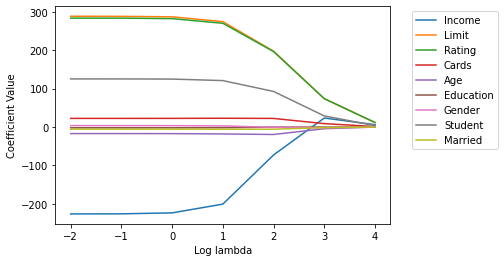

In [30]:
mean_betas = np.mean(ridge_cv.B_trained, 0)
pred_names = df.columns
for i_beta in range(mean_betas.shape[1]):
    plt.plot(np.log10(ridge_cv.lambdas), mean_betas[:, i_beta], label = pred_names[i_beta])
plt.legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.xlabel('Log lambda')
plt.ylabel('Coefficient Value')
plt.show()

Text(0, 0.5, 'CV MSE')

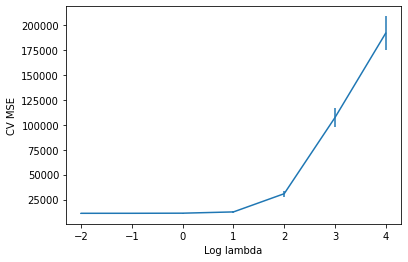

In [31]:
se = np.std(ridge_cv.cv_vals, 0) / np.sqrt(ridge_cv.cv_vals.shape[0])
plt.errorbar(np.log10(ridge_cv.lambdas), np.mean(ridge_cv.cv_vals, 0), yerr = se)
plt.xlabel('Log lambda')
plt.ylabel('CV MSE')

In [32]:
# lambda with lowest cv mse
ridge_cv.best_lambda

0.01

In [33]:
# coefficient vector
ridge_cv.B

array([[-246.73119689],
       [ 298.79170834],
       [ 291.73711532],
       [  20.76175164],
       [ -14.50287712],
       [  -2.33128066],
       [   4.30462658],
       [ 125.99106492],
       [  -5.01065371]])

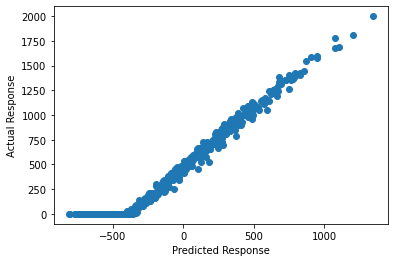

In [34]:
# predict responses and compare against actual responses
y_hat = ridge_cv.predict(ridge_cv.x)
plt.scatter(y_hat, ridge_cv.y)
plt.xlabel('Predicted Response')
plt.ylabel('Actual Response')
plt.show()

## Sklearn

In [35]:
from sklearn.linear_model import RidgeCV

In [36]:
ridge_sklearn = RidgeCV(
    alphas = 10 ** np.arange(-2., 5.),
    fit_intercept = False,
    normalize = False,
    cv = 5
)

In [37]:
X = (X - np.mean(X, 0)) / np.std(X, 0)
Y -= np.mean(Y)

In [38]:
ridge_sklearn.fit(X, Y)

RidgeCV(alphas=array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
        cv=5, fit_intercept=False, gcv_mode=None, normalize=False, scoring=None,
        store_cv_values=False)

In [39]:
ridge_sklearn.coef_

array([-271.23122766,  369.52441617,  242.60689635,   21.49206153,
        -11.27075014,   -3.04525924,    5.09410044,  127.07827162,
         -3.97552834])

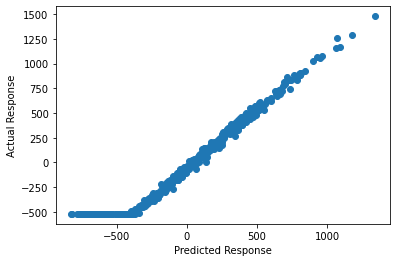

In [40]:
y_hat = ridge_sklearn.predict(X)
plt.scatter(y_hat, Y)
plt.xlabel('Predicted Response')
plt.ylabel('Actual Response')
plt.show()